In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
#Data collection
start = dt.datetime(2018,1,1)
end =  dt.datetime.now()
df = yf.download("^BSESN", start, end, interval="1d")

In [3]:
df.to_csv('sensex.csv')

In [4]:
DF = pd.read_csv('sensex.csv')

In [5]:
DF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,34059.988281,34101.128906,33766.148438,33812.750000,33812.750000,7500
1,2018-01-02,33913.550781,33964.140625,33703.371094,33812.261719,33812.261719,10600
2,2018-01-03,33929.609375,33998.371094,33765.429688,33793.378906,33793.378906,9000
3,2018-01-04,33912.488281,33995.398438,33802.128906,33969.640625,33969.640625,10500
4,2018-01-05,34021.269531,34188.851562,34020.839844,34153.851562,34153.851562,14700


In [6]:
data = DF.reset_index()['Close']

In [7]:
data.shape

(864,)

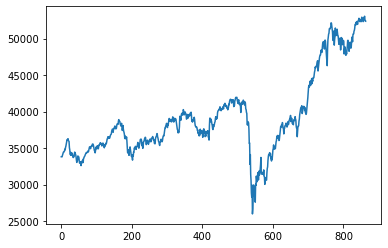

In [8]:
plt.plot(data)

since LSTM is being used in this project, I'm going to use MinMax scaler cause LSTM is highly sensitive to the scale of data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [10]:
data.shape

(864, 1)

Splitting dataset into train and test set

In [11]:
train_size = int(len(data)*0.6)
train_set, test_set = data[0:train_size, :], data[train_size:len(data), :1]

In [12]:
## converting the array of values into dataset matrices(x & y)
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step])
    return numpy.array(dataX), numpy.array(dataY)      

In [13]:
##reshaping the data
time_step = 100
x_train, y_train = create_dataset(train_set, time_step)
x_test, y_test = create_dataset(test_set, time_step)

In [14]:
##reshaping the data to feed into a stacked LSTM [samples, time_steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Creating the stacked LSTM model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
7/7 [==============================] - 4s 249ms/step - loss: 0.0602 - val_loss: 0.0049
Epoch 2/50
7/7 [==============================] - 1s 96ms/step - loss: 0.0078 - val_loss: 0.0781
Epoch 3/50
7/7 [==============================] - 1s 117ms/step - loss: 0.0049 - val_loss: 0.0141
Epoch 4/50
7/7 [==============================] - 1s 135ms/step - loss: 0.0038 - val_loss: 0.0336
Epoch 5/50
7/7 [==============================] - 1s 92ms/step - loss: 0.0025 - val_loss: 0.0385
Epoch 6/50
7/7 [==============================] - 1s 92ms/step - loss: 0.0021 - val_loss: 0.0223
Epoch 7/50
7/7 [==============================] - 1s 91ms/step - loss: 0.0019 - val_loss: 0.0340
Epoch 8/50
7/7 [==============================] - 1s 91ms/step - loss: 0.0018 - val_loss: 0.0235
Epoch 9/50
7/7 [==============================] - 1s 91ms/step - loss: 0.0016 - val_loss: 0.0276
Epoch 10/50
7/7 [==============================] - 1s 129ms/step - loss: 0.0016 - val_loss: 0.0208
Epoch 11/50
7/7 [========

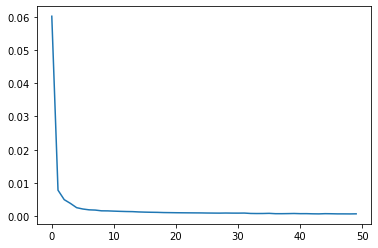

In [19]:
loss_per_epochs = model.history.history['loss']
plt.plot(range(len(loss_per_epochs)), loss_per_epochs)

In [20]:
import tensorflow as tf

In [21]:
### making predictions and checking performance matrices
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [22]:
###inverse_transforming the data to it's original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [23]:
###calculating the rmse score of performance matrices
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

37951.52267413143

In [24]:
math.sqrt(mean_squared_error(y_test, test_predict))

45565.84689633131

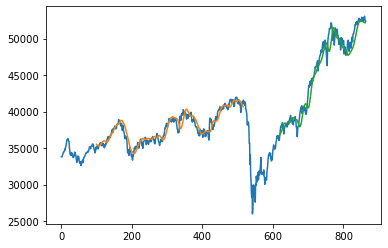

In [25]:
###plotting
# shift train predictions for plotting
look_back = 100
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test prediction for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
#plotting baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Prediction for next 30 days

In [26]:
x_input = test_set[len(test_set)-100: ].reshape(1, -1)
x_input.shape

(1, 100)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
##predicting the data
from numpy import array
lst_output = []
n_steps = 100
i = 0
while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} Day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} Day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
print(lst_output)

[0.96657157]
101
1 Day input [0.96673381 0.96488858 0.9501013  0.93609733 0.92003257 0.87772402
 0.87798589 0.91604083 0.9255563  0.85392468 0.88162154 0.89813401
 0.94052812 0.91841905 0.90213902 0.9034595  0.92504554 0.93442855
 0.91642448 0.90176071 0.90061135 0.87984051 0.85822893 0.88193175
 0.87872015 0.88906798 0.85689142 0.82955152 0.85054542 0.89221263
 0.8690376  0.88826967 0.85611619 0.85767012 0.8746746  0.87779385
 0.87207274 0.80898743 0.8333906  0.84298009 0.84402729 0.81142683
 0.80242833 0.81627474 0.80880535 0.82757138 0.84816821 0.87733691
 0.87852263 0.84219259 0.83983457 0.82265883 0.83832133 0.84837584
 0.86878871 0.8562081  0.83881074 0.84035284 0.87168159 0.89430878
 0.88357181 0.87109537 0.90713136 0.91124674 0.91071607 0.92475149
 0.92836015 0.93972403 0.95873014 0.9586355  0.95548118 0.96962597
 0.96473636 0.9731749  0.97121943 0.95888525 0.97213909 0.97857685
 0.98141245 0.9895946  0.97958222 0.97298343 0.97376357 0.98225939
 0.98278573 0.97234628 0.98685942

13 Day output [[0.9278838]]
14 Day input [0.91841905 0.90213902 0.9034595  0.92504554 0.93442855 0.91642448
 0.90176071 0.90061135 0.87984051 0.85822893 0.88193175 0.87872015
 0.88906798 0.85689142 0.82955152 0.85054542 0.89221263 0.8690376
 0.88826967 0.85611619 0.85767012 0.8746746  0.87779385 0.87207274
 0.80898743 0.8333906  0.84298009 0.84402729 0.81142683 0.80242833
 0.81627474 0.80880535 0.82757138 0.84816821 0.87733691 0.87852263
 0.84219259 0.83983457 0.82265883 0.83832133 0.84837584 0.86878871
 0.8562081  0.83881074 0.84035284 0.87168159 0.89430878 0.88357181
 0.87109537 0.90713136 0.91124674 0.91071607 0.92475149 0.92836015
 0.93972403 0.95873014 0.9586355  0.95548118 0.96962597 0.96473636
 0.9731749  0.97121943 0.95888525 0.97213909 0.97857685 0.98141245
 0.9895946  0.97958222 0.97298343 0.97376357 0.98225939 0.98278573
 0.97234628 0.98685942 0.9952085  0.98821092 0.98134334 0.97887047
 0.97280885 0.9789429  0.99354492 0.99284977 1.         0.98205552
 0.97530538 0.97480674

26 Day output [[0.87077504]]
27 Day input [0.85689142 0.82955152 0.85054542 0.89221263 0.8690376  0.88826967
 0.85611619 0.85767012 0.8746746  0.87779385 0.87207274 0.80898743
 0.8333906  0.84298009 0.84402729 0.81142683 0.80242833 0.81627474
 0.80880535 0.82757138 0.84816821 0.87733691 0.87852263 0.84219259
 0.83983457 0.82265883 0.83832133 0.84837584 0.86878871 0.8562081
 0.83881074 0.84035284 0.87168159 0.89430878 0.88357181 0.87109537
 0.90713136 0.91124674 0.91071607 0.92475149 0.92836015 0.93972403
 0.95873014 0.9586355  0.95548118 0.96962597 0.96473636 0.9731749
 0.97121943 0.95888525 0.97213909 0.97857685 0.98141245 0.9895946
 0.97958222 0.97298343 0.97376357 0.98225939 0.98278573 0.97234628
 0.98685942 0.9952085  0.98821092 0.98134334 0.97887047 0.97280885
 0.9789429  0.99354492 0.99284977 1.         0.98205552 0.97530538
 0.97480674 0.96657157 0.96556211 0.9640618  0.96208775 0.9596892
 0.95692986 0.95387322 0.95057827 0.94709337 0.94345784 0.93970066
 0.93584353 0.93190128 0

In [29]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [30]:
len(data)

864

In [31]:
data1 = data.tolist()
data1.extend(lst_output)

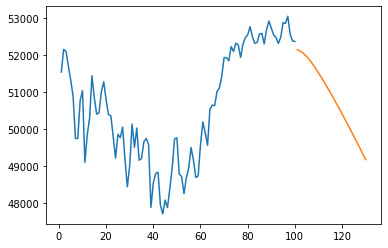

In [32]:
plt.plot(day_new, scaler.inverse_transform(data[len(data)-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

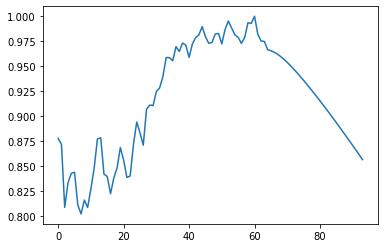

In [35]:
data1 = data.tolist()
data1.extend(lst_output)
plt.plot(data1[800:])